In [1]:
import sys

import oct2py
import numpy as np
from numpy.testing import assert_allclose
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import scipy.ndimage

oc = oct2py.Oct2Py()
oc.pkg('load', 'image')

sys.path.append('../lccd_python/')
import blob_detector
import test_utils
import data_synthesizer

X = 512
Y = 512
T = 1000
np.random.seed(314)

bd = blob_detector.BlobDetector(**{'filtersize1': 100,
  'filtersize2': 4,
  'sigma': 1.25,
  'fsize': 7,
  'min_area': 20,
  'max_area': 50})

v = data_synthesizer.syntesize_data(X, Y, T, 64)
tm = v[:, :, :100]
%load_ext line_profiler
%lprun -T lprof0 -f bd.apply bd.apply(tm)


*** Profile printout saved to text file 'lprof0'. 


Timer unit: 1e-06 s

Total time: 5.14693 s
File: /home/nmamada/lccd-python/profiles/../lccd_python/blob_detector.py
Function: apply at line 59

Line #      Hits         Time  Per Hit   % Time  Line Contents
    59                                               def apply(self, tv):
    60         1          1.0      1.0      0.0          X, Y, T = tv.shape
    61         1          3.0      3.0      0.0          tv = tv.reshape(-1, T)
    62         2     184191.0  92095.5      3.6          smooth_tv = np.maximum(
    63         2     618251.0 309125.5     12.0              self.conv2(tv, self.mavefil2, mode='same')\
    64         1    4250795.0 4250795.0     82.6                  - self.conv2(tv, self.mavefil1, mode='same'),
    65         1          3.0      3.0      0.0              0
    66                                                   )
    67         1      21809.0  21809.0      0.4          max_lumi_map = np.max(smooth_tv, axis=1).reshape(X, Y)
    68         2       1254.0  

In [2]:
!cat lprof0

Timer unit: 1e-06 s

Total time: 5.14693 s
File: /home/nmamada/lccd-python/profiles/../lccd_python/blob_detector.py
Function: apply at line 59

Line #      Hits         Time  Per Hit   % Time  Line Contents
    59                                               def apply(self, tv):
    60         1          1.0      1.0      0.0          X, Y, T = tv.shape
    61         1          3.0      3.0      0.0          tv = tv.reshape(-1, T)
    62         2     184191.0  92095.5      3.6          smooth_tv = np.maximum(
    63         2     618251.0 309125.5     12.0              self.conv2(tv, self.mavefil2, mode='same')\
    64         1    4250795.0 4250795.0     82.6                  - self.conv2(tv, self.mavefil1, mode='same'),
    65         1          3.0      3.0      0.0              0
    66                                                   )
    67         1      21809.0  21809.0      0.4          max_lumi_map = np.max(smooth_tv, axis=1).reshape(X, Y)
    68         2       1254.0  

# Profile bottleneck

convolution operation with large kenerl (1, 100) covers almost 90 % of calculation time (line 63).
GPU computation may reduce calculation time.

# Comparison of GPU and CPU
Calculation times of convolution operation by CPU (scipy.ndimage.convolution2d) and CPU (cupyx.scipy.ndimage.convolution2d) are compared.  
convolution target array is have size (length, 100) where length = side * side  
convolution kernel is ones(1, 100) / 100  
The results (cell 42 and 43) show gpu can speed up computation.

In [3]:
# environment
# GPU
!nvidia-smi

Fri May 13 21:44:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0  On |                  N/A |
| 51%   29C    P5    N/A /  75W |    408MiB /  4038MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# CPU
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 113
model name	: AMD Ryzen 9 3900X 12-Core Processor
stepping	: 0
microcode	: 0x8701021
cpu MHz		: 2200.000
cache size	: 512 KB
physical id	: 0
siblings	: 24
core id		: 0
cpu cores	: 12
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 16
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 hw_pstate ssbd mba ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cq

In [5]:
# OS
!cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.4 LTS"


In [6]:
import time

import cupy as cp
import cupyx.scipy.signal

kernel = cp.asarray(bd.mavefil1)
# Check that CPU and GPU have the same result
arr = np.random.uniform(0, 1, size=(1024, 100))
arr_gpu = cp.asarray(arr)
result_gpu = cupyx.scipy.signal.convolve2d(arr_gpu, kernel, mode='same')
result_cpu = bd.conv2(arr, bd.mavefil1, mode='same')
assert_allclose(cp.asnumpy(result_gpu), result_cpu)

In [7]:

sides = [16, 32, 64, 128, 256, 512, 1024]

times_cpu = {}
for side in sides:
    length = side**2
    times_cpu[length] = []
    for i in range(5):
        arr = np.random.uniform(0, 1, size=(length, 100))
        before = time.time()
        for j in range(5):
            res = bd.conv2(arr, bd.mavefil1, mode='same')
        times_cpu[length].append((time.time()-before) / 5)

In [8]:
times_gpu = {}
kernel = cp.asarray(bd.mavefil1)

for side in sides:
    length = side**2
    times_gpu[length] = []
    for i in range(5):
        arr = np.random.uniform(0, 1, size=(length, 100))
        before = time.time()
        for j in range(5):
            arr_gpu = cp.asarray(arr) # Include cpu-to-gpu transport
            res = cupyx.scipy.signal.convolve2d(arr_gpu, kernel, mode='same')
            res_cpu = cp.asnumpy(res) # Include gpu-to-cpu transport
        times_gpu[length].append((time.time()-before) / 5)

In [9]:
times_gpu_f32 = {}
kernel = cp.asarray(bd.mavefil1).astype('float32')

for side in sides:
    length = side**2
    times_gpu_f32[length] = []
    for i in range(5):
        arr = np.random.uniform(0, 1, size=(length, 100)).astype('float32')
        before = time.time()
        for j in range(5):
            arr_gpu = cp.asarray(arr) # Include cpu-to-gpu transport
            res = cupyx.scipy.signal.convolve2d(arr_gpu, kernel, mode='same')
            res_cpu = cp.asnumpy(res) # Include gpu-to-cpu transport
        times_gpu_f32[length].append((time.time()-before) / 5)

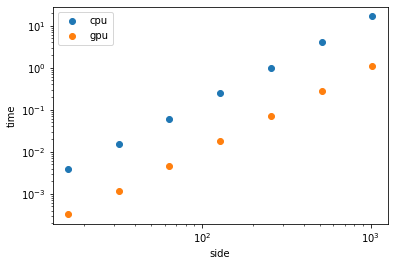

In [10]:
x = sides
y_cpu = [np.median(times_cpu[x_**2]) for x_ in x]
y_gpu = [np.median(times_gpu[x_**2]) for x_ in x]

plt.scatter(x, y_cpu, label='cpu')
plt.scatter(x, y_gpu, label='gpu')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('side')
plt.ylabel('time')
plt.legend()

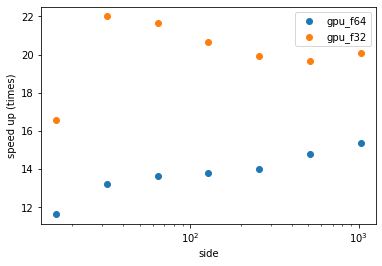

In [11]:
plt.scatter(x, np.array(y_cpu)/np.array(y_gpu), label='gpu_f64')
y_gpu_f32 = [np.median(times_gpu_f32[x_**2]) for x_ in x]
plt.scatter(x, np.array(y_cpu)/np.array(y_gpu_f32), label='gpu_f32')
plt.xscale('log')
plt.xlabel('side')
plt.ylabel('speed up (times)')
plt.legend()